# Training pipeline for GLCM models (train + save)

In [1]:
import sys
import os
from git_root import git_root

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam

sys.path.append(git_root("utils"))
from utils import load_params

from fetch_data import fetch_data_local
from fetch_data import to_numpy_arrays, prepare_tf_dataset

sys.path.append(git_root("models"))
from GLCM_model import setup_model
import MFCC_model as mfcc

from validation_utils import plot_history

In [2]:
print(tf.__version__)

2.0.0


In [3]:
params = load_params()

In [4]:
angles = params["GLCM"]["mel_map"]["angles_in_deg"]

In [5]:
train = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}
test = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}

In [6]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        train[map_type][angle] = fetch_data_local(
            map_type=map_type, train=True, angle=angle
        )
        test[map_type][angle] = fetch_data_local(
            map_type=map_type, train=False, angle=angle
        )

Map: spectrogram, angle: 0
Fetching: data_spectrogram_angle_0_train.json
Fetching: data_spectrogram_angle_0_test.json
Map: mel_map, angle: 0
Fetching: data_mel_map_angle_0_train.json
Fetching: data_mel_map_angle_0_test.json
Map: mel_map, angle: 45
Fetching: data_mel_map_angle_45_train.json
Fetching: data_mel_map_angle_45_test.json
Map: mel_map, angle: 90
Fetching: data_mel_map_angle_90_train.json
Fetching: data_mel_map_angle_90_test.json
Map: mel_map, angle: 135
Fetching: data_mel_map_angle_135_train.json
Fetching: data_mel_map_angle_135_test.json


In [7]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(train[map_type][angle].shape)
        print("test")
        print(test[map_type][angle].shape)

Map: spectrogram, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 45
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 90
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 135
train
(12600, 4)
test
(1400, 4)


In [8]:
for map_type in train:
    for angle in train[map_type]:
        train[map_type][angle] = to_numpy_arrays(
            train[map_type][angle]
        )
        test[map_type][angle] = to_numpy_arrays(
            test[map_type][angle]
        )

In [9]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(len(train[map_type][angle][0]))
        print(len(train[map_type][angle][1]))
        print("test")
        print(len(test[map_type][angle][0]))
        print(len(test[map_type][angle][1]))

Map: spectrogram, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 45
train
12600
12600
test
1400
1400
Map: mel_map, angle: 90
train
12600
12600
test
1400
1400
Map: mel_map, angle: 135
train
12600
12600
test
1400
1400


Now we also need a stacked dataset for the combined i-GLCM model:

In [10]:
stacked_train = (
    [
        np.stack([
            np.squeeze(train["mel_map"][angle][0][i]) for angle in angles
        ], -1) for i in range(len(train["mel_map"][0][0]))
    ],
    train["mel_map"][0][1]
)
stacked_test = (
    [
        np.stack([
            np.squeeze(test["mel_map"][angle][0][i]) for angle in angles
        ], -1) for i in range(len(test["mel_map"][0][0]))
    ],
    test["mel_map"][0][1]
)

In [11]:
print(stacked_train[0][0].shape)

(15, 15, 4)


In [12]:
for map_type in train:
    for angle in train[map_type]:
        train[map_type][angle] = prepare_tf_dataset(
            train[map_type][angle][0], train[map_type][angle][1]
        )
        test[map_type][angle] = prepare_tf_dataset(
            test[map_type][angle][0], test[map_type][angle][1]
        )

In [13]:
stacked_train = prepare_tf_dataset(
    stacked_train[0], stacked_train[1]
)
stacked_test = prepare_tf_dataset(
    stacked_test[0], stacked_test[1]
)

In [14]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        tr_sample_batch, tr_label_batch = next(
            iter(train[map_type][angle])
        )
        te_sample_batch, te_label_batch = next(
            iter(test[map_type][angle])
        )
        print("train")
        print(tr_sample_batch.shape, tr_label_batch.shape)
        print("test")
        print(te_sample_batch.shape, te_label_batch.shape)

Map: spectrogram, angle: 0
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 0
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 45
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 90
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)
Map: mel_map, angle: 135
train
(32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32,)


In [15]:
print(f"Map: stacked mel_maps")
tr_sample_batch, tr_label_batch = next(iter(stacked_train))
te_sample_batch, te_label_batch = next(iter(stacked_test))
print("train")
print(tr_sample_batch.shape, tr_label_batch.shape)
print("test")
print(te_sample_batch.shape, te_label_batch.shape)

Map: stacked mel_maps
train
(32, 15, 15, 4) (32,)
test
(32, 15, 15, 4) (32,)


## Spectrogram with angle 0

In [16]:
#We load the model
net_spec = setup_model()
net_spec.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 10, 12)        444       
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 5, 5, 12)          0         
_________________________________________________________________
affine (AffineScalar)        (None, 5, 5, 12)          2         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 3, 6)           654       
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                70        
Total params: 1,170
Trainable params: 1,170
Non-trainable params: 0
______________________________________________________

In [17]:
net_spec.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_spec = net_spec.fit(
    train["spectrogram"][0], 
    epochs=500, 
    validation_data=test["spectrogram"][0]
)

Epoch 1/500
394/394 [==============================] - 5s 13ms/step - loss: 2.3135 - accuracy: 0.0637 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 3s 7ms/step - loss: 2.3115 - accuracy: 0.0267 - val_loss: 2.2996 - val_accuracy: 0.1000
Epoch 3/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3082 - accuracy: 0.0426 - val_loss: 2.2983 - val_accuracy: 0.1164
Epoch 4/500
394/394 [==============================] - 2s 6ms/step - loss: 2.3060 - accuracy: 0.0548 - val_loss: 2.2956 - val_accuracy: 0.1300
Epoch 5/500
394/394 [==============================] - 2s 6ms/step - loss: 2.3026 - accuracy: 0.0663 - val_loss: 2.2927 - val_accuracy: 0.1436
Epoch 6/500
394/394 [==============================] - 2s 5ms/step - loss: 2.2975 - accuracy: 0.0869 - val_loss: 2.2888 - val_accuracy: 0.1693
Epoch 7/500
394/394 [==============================] - 2s 5ms/step - loss: 2.2970 - accuracy: 0.0863 - val_loss: 2.2813 - val_accurac

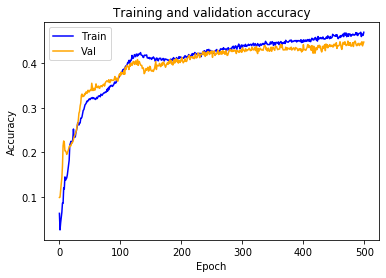

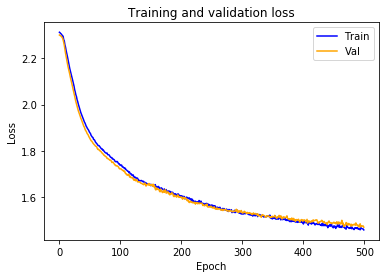

In [19]:
plot_history(history_spec)

In [20]:
print(f"Final validation accuracy is: {history_spec.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.447


In [21]:
overwrite = True
if overwrite:
    try:
        file_path = git_root("models", "saved_models", "glcm_spec_angle0.h5")
        net_spec.save_weights(file_path, overwrite=overwrite)
    except:
        print("Runtime Error: you might want to check the saved model.")
else:
    print("CAN'T OVERWRITE.")

Runtime Error: you might want to check the saved model.


## Mel map with angle 0

In [22]:
#We load the model
net_mel_0 = setup_model()

In [23]:
net_mel_0.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_0 = net_mel_0.fit(
    train["mel_map"][0], 
    epochs=500, 
    validation_data=test["mel_map"][0]
)

Epoch 1/500
394/394 [==============================] - 4s 11ms/step - loss: 2.3129 - accuracy: 0.0752 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3074 - accuracy: 0.0232 - val_loss: 2.3021 - val_accuracy: 0.1000
Epoch 3/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3061 - accuracy: 0.0306 - val_loss: 2.3022 - val_accuracy: 0.1579
Epoch 4/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3049 - accuracy: 0.0223 - val_loss: 2.3019 - val_accuracy: 0.1093
Epoch 5/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3077 - accuracy: 0.0051 - val_loss: 2.3018 - val_accuracy: 0.1000
Epoch 6/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3101 - accuracy: 0.0226 - val_loss: 2.3023 - val_accuracy: 0.1000
Epoch 7/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3061 - accuracy: 0.0700 - val_loss: 2.3023 - val_accurac

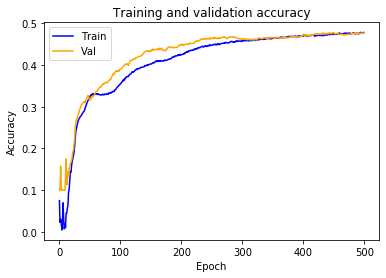

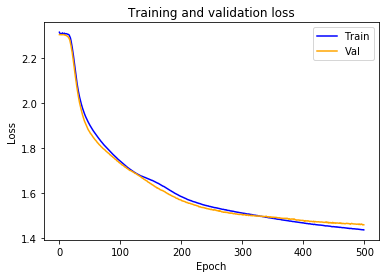

In [25]:
plot_history(history_mel_0)

In [26]:
print(f"Final validation accuracy is: {history_mel_0.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.476


In [27]:
#overwrite = False
if overwrite:
    try:
        file_path = git_root("models", "saved_models", "glcm_mel_angle0.h5")
        net_mel_0.save(file_path)
    except:
        print("Runtime Error: you might want to check the saved model.")
else:
    print("CAN'T OVERWRITE.")

Runtime Error: you might want to check the saved model.


## Mel map with angle 45

In [28]:
#We load the model
net_mel_45 = setup_model()

In [29]:
net_mel_45.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_45 = net_mel_45.fit(
    train["mel_map"][45], 
    epochs=500, 
    validation_data=test["mel_map"][45]
)

Epoch 1/500
394/394 [==============================] - 3s 8ms/step - loss: 2.3100 - accuracy: 0.0852 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3063 - accuracy: 0.0994 - val_loss: 2.3026 - val_accuracy: 0.0964
Epoch 3/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3068 - accuracy: 0.1002 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 4/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3100 - accuracy: 0.0593 - val_loss: 2.3026 - val_accuracy: 0.1014
Epoch 5/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3052 - accuracy: 0.1071 - val_loss: 2.3025 - val_accuracy: 0.0993
Epoch 6/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3081 - accuracy: 0.0216 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/500
394/394 [==============================] - 2s 4ms/step - loss: 2.3070 - accuracy: 0.0321 - val_loss: 2.3031 - val_accuracy

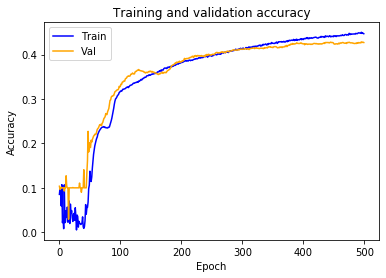

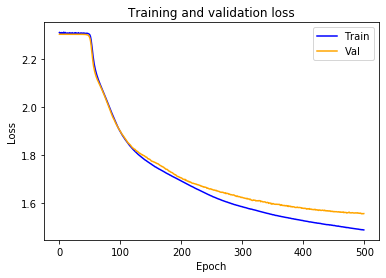

In [31]:
plot_history(history_mel_45)

In [32]:
print(f"Final validation accuracy is: {history_mel_45.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.427


In [33]:
#overwrite = False
if overwrite:
    try:
        file_path = git_root("models", "saved_models", "glcm_mel_angle45.h5")
        net_mel_45.save(file_path)
    except:
        print("Runtime Error: you might want to check the saved model.")
else:
    print("CAN'T OVERWRITE.")

Runtime Error: you might want to check the saved model.


## Mel map with angle 90

In [34]:
#We load the model
net_mel_90 = setup_model()

In [35]:
net_mel_90.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_90 = net_mel_90.fit(
    train["mel_map"][90], 
    epochs=500, 
    validation_data=test["mel_map"][90]
)

Epoch 1/500
394/394 [==============================] - 3s 7ms/step - loss: 2.3121 - accuracy: 0.1023 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3082 - accuracy: 0.1130 - val_loss: 2.3014 - val_accuracy: 0.1136
Epoch 3/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3065 - accuracy: 0.0759 - val_loss: 2.3006 - val_accuracy: 0.1343
Epoch 4/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3068 - accuracy: 0.0708 - val_loss: 2.2996 - val_accuracy: 0.1086
Epoch 5/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3057 - accuracy: 0.0851 - val_loss: 2.2983 - val_accuracy: 0.1336
Epoch 6/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3037 - accuracy: 0.0867 - val_loss: 2.2961 - val_accuracy: 0.1307
Epoch 7/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3021 - accuracy: 0.0805 - val_loss: 2.2923 - val_accuracy

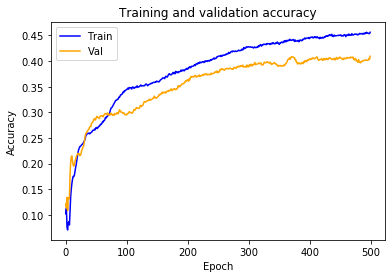

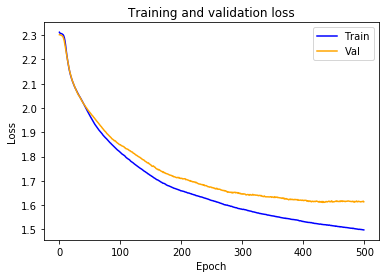

In [37]:
plot_history(history_mel_90)

In [38]:
print(f"Final validation accuracy is: {history_mel_90.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.409


In [39]:
#overwrite = False
if overwrite:
    try:
        file_path = git_root("models", "saved_models", "glcm_mel_angle90.h5")
        net_mel_90.save(file_path)
    except:
        print("Runtime Error: you might want to check the saved model.")
else:
    print("CAN'T OVERWRITE.")

Runtime Error: you might want to check the saved model.


## Mel map with angle 135

In [40]:
#We load the model
net_mel_135 = setup_model()

In [41]:
net_mel_135.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_135 = net_mel_135.fit(
    train["mel_map"][135], 
    epochs=500, 
    validation_data=test["mel_map"][135]
)

Epoch 1/500
394/394 [==============================] - 3s 7ms/step - loss: 2.3123 - accuracy: 0.0905 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3078 - accuracy: 0.0929 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3067 - accuracy: 0.0918 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 4/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3062 - accuracy: 0.0758 - val_loss: 2.3020 - val_accuracy: 0.1000
Epoch 5/500
394/394 [==============================] - 1s 3ms/step - loss: 2.3067 - accuracy: 0.0678 - val_loss: 2.3018 - val_accuracy: 0.1000
Epoch 6/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3063 - accuracy: 0.0640 - val_loss: 2.3018 - val_accuracy: 0.1000
Epoch 7/500
394/394 [==============================] - 1s 4ms/step - loss: 2.3070 - accuracy: 0.0820 - val_loss: 2.3013 - val_accuracy

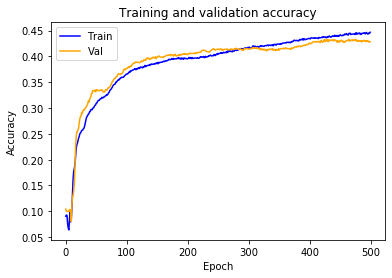

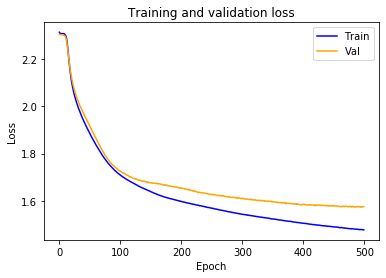

In [43]:
plot_history(history_mel_135)

In [44]:
print(f"Final validation accuracy is: {history_mel_135.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.429


In [45]:
#overwrite = False
if overwrite:
    try:
        file_path = git_root("models", "saved_models", "glcm_mel_angle135.h5")
        net_mel_135.save(file_path)
    except:
        print("Runtime Error: you might want to check the saved model.")
else:
    print("CAN'T OVERWRITE.")

Runtime Error: you might want to check the saved model.


# Stacked mel maps

In [73]:
#We load the model
net_mel_stacked = setup_model(M=4)
net_mel_stacked.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 10, 12)        1740      
_________________________________________________________________
pooling1 (AveragePooling2D)  (None, 5, 5, 12)          0         
_________________________________________________________________
affine (AffineScalar)        (None, 5, 5, 12)          2         
_________________________________________________________________
conv2 (Conv2D)               (None, 3, 3, 6)           654       
_________________________________________________________________
pooling2 (GlobalAveragePooli (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                70        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
___________________________________________________

In [74]:
net_mel_stacked.compile(
    optimizer=Adam(learning_rate=0.0001, epsilon=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [75]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history_mel_stacked = net_mel_stacked.fit(
    stacked_train, 
    epochs=500, 
    validation_data=stacked_test
)

Epoch 1/500
394/394 [==============================] - 7s 17ms/step - loss: 2.3114 - accuracy: 0.1056 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 3s 8ms/step - loss: 2.3064 - accuracy: 0.0625 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/500
394/394 [==============================] - 2s 6ms/step - loss: 2.3057 - accuracy: 0.0574 - val_loss: 2.3020 - val_accuracy: 0.1221
Epoch 4/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3085 - accuracy: 0.0673 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 5/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3063 - accuracy: 0.1115 - val_loss: 2.3025 - val_accuracy: 0.0971
Epoch 6/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3068 - accuracy: 0.0837 - val_loss: 2.3023 - val_accuracy: 0.0971
Epoch 7/500
394/394 [==============================] - 2s 5ms/step - loss: 2.3064 - accuracy: 0.0787 - val_loss: 2.3024 - val_accurac

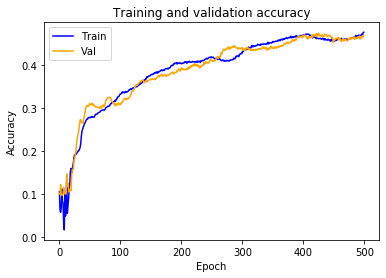

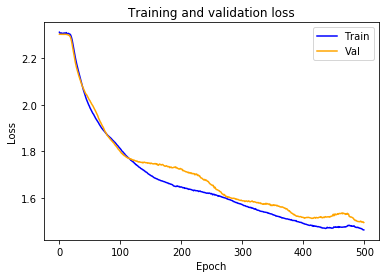

In [76]:
plot_history(history_mel_stacked)

In [77]:
print(f"Final validation accuracy is: {history_mel_stacked.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.467


In [78]:
overwrite = True
if overwrite:
    try:
        file_path = git_root("models", "saved_models", "glcm_mel_stacked.h5")
        net_mel_stacked.save(file_path)
    except:
        print("Runtime Error: you might want to check the saved model.")
else:
    print("CAN'T OVERWRITE.")

Runtime Error: you might want to check the saved model.


## Combined loss curves

In [79]:
val_losses = pd.DataFrame(
    {
        "s-GLCM(a)": history_spec.history["val_loss"],
        "GLCM(a)": history_mel_0.history["val_loss"],
        "GLCM(b)": history_mel_45.history["val_loss"],
        "GLCM(c)": history_mel_90.history["val_loss"],
        "GLCM(d)": history_mel_135.history["val_loss"],
        "i-GLCM": history_mel_stacked.history["val_loss"]
    }
).melt()

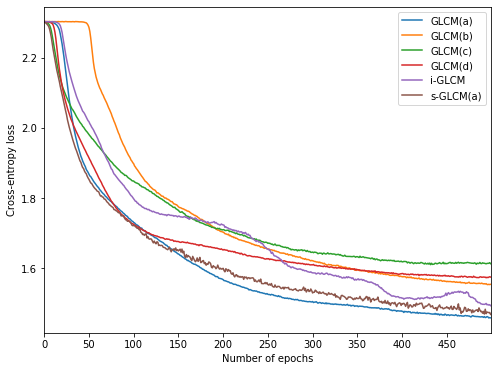

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))
for label, df in val_losses.groupby("variable"):
    df["value"].reset_index(drop=True).plot(ax=ax, label=label)
plt.ylabel("Cross-entropy loss")
plt.xlabel("Number of epochs")
plt.xticks(range(0, 500, 50))
plt.legend()

In [81]:
fig.savefig(git_root("training", "loss_curves.jpg"))